In [10]:
import os

import pandas as pd
import torch
import torch.nn as nn
from comet_ml import Experiment
import numpy as np

import arccnet.models.cutouts.config as config
import arccnet.models.dataset_utils as ut_d
import arccnet.models.train_utils as ut_t
import arccnet.visualisation.utils as ut_v

from astropy.io import fits
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import timm

from arccnet.models import labels as lbs
import seaborn as sns

In [2]:
# Generate run ID and weights directory
run_id, weights_dir = ut_t.generate_run_id(config)

# Create weights directory if it doesn't exist
os.makedirs(weights_dir, exist_ok=True)

In [3]:
experiment = None
if experiment:
    # Initialize Comet experiment
    run_comet = Experiment(project_name=config.project_name, workspace="arcaff")
    run_comet.add_tags([config.model_name])
    run_comet.log_parameters(
        {
            "model_name": config.model_name,
            "batch_size": config.batch_size,
            "GPU": f"GPU{config.gpu_index}_{torch.cuda.get_device_name()}" if torch.cuda.is_available() else "CPU",
            "num_epochs": config.num_epochs,
            "patience": config.patience,
        }
    )
    run_comet.log_code(config.__file__)
    run_comet.log_code(ut_t.__file__)
    run_comet.add_tags(config.other_tags)

In [4]:
# Load Dataset
base_dir = '/ARCAFF/data/cutouts_from_fulldisk/'
df = pd.read_parquet(os.path.join(base_dir, 'dataframe.parquet'))

label_mapping = {
    "Alpha": "Alpha",
    "Beta": "Beta",
    "Beta-Delta": "Beta",
    "Beta-Gamma": "Beta-Gamma",
    "Beta-Gamma-Delta": "Beta-Gamma",
    "Gamma": None,
    "Gamma-Delta": None,
}

df["grouped_labels"] = df["magnetic_class"].map(label_mapping)
df['Index'] = range(len(df))
df

,target_time.jd1,target_time.jd2,datetime.jd1,datetime.jd2,instrument,path,processed_path_image,target_time_arc.jd1,target_time_arc.jd2,datetime_arc.jd1,...,record_HARPNUM_arc,record_HARPNUM_arc.mask,quicklook_path,quicklook_path.mask,time,datetime,width,height,grouped_labels,Index
30,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.108398,0.062500,Alpha,0
31,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.082031,0.058594,Alpha,1
32,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.068359,0.059570,Alpha,2
33,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.110352,0.060547,Alpha,3
34,2450264.0,0.5,2450265.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,0.5,2450265.0,...,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450265e+06,1996-06-30 00:01:30.000,0.051758,0.059570,Alpha,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,2459818.0,0.5,2459818.0,0.499111,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459818.0,0.5,2459818.0,...,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459818e+06,2022-08-26 23:58:43.200,0.146240,0.056396,Beta,4927
27390,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.145508,0.057373,Beta,4928
27391,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,8546,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.186279,0.108398,Beta,4929
27392,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,8539,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.085937,0.064697,Beta,4930


In [17]:
img_fit[0].data

ValueError: I/O operation on closed file

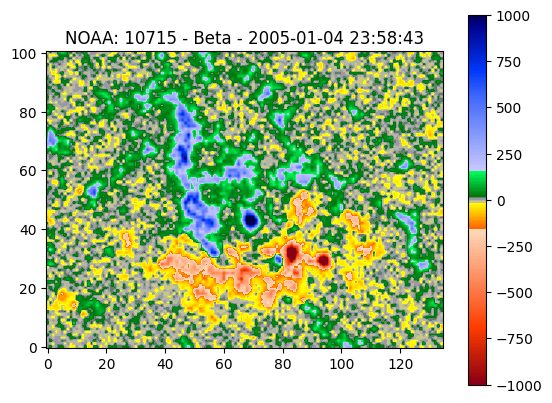

In [ ]:
row = df.iloc[1000]
filename = (
    f"{row['instrument']}_{row['datetime'].strftime('%Y%m%d_%H%M%S')}_NOAA_{row['NOAA']}_{row['magnetic_class']}"
)

with fits.open(os.path.join(base_dir, 'fits', f'{filename}.fits')) as img_fit:
    data = img_fit[0].data
    header = img_fit[0].header
plt.imshow(data, origin='lower', cmap = ut_v.magnetic_map, vmin=-1000,vmax=1000)
plt.title(f"{row['instrument']} - NOAA: {row['NOAA']} - {row['magnetic_class']} - {row['datetime']}")
plt.colorbar()

In [5]:
split_df = df.dropna(subset=["grouped_labels", "NOAA"])
fold_df = ut_d.split_data(split_df, label_col="grouped_labels", group_col="NOAA", random_state=42)
df_tr = ut_d.assign_fold_sets(df, fold_df)

/ARCAFF/ARCCnet/arccnet/models/dataset_utils.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[train_df.index, f"Fold {fold}"] = "train"
/ARCAFF/ARCCnet/arccnet/models/dataset_utils.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[train_df.index, f"Fold {fold}"] = "train"
/ARCAFF/ARCCnet/arccnet/models/dataset_utils.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [25]:
data = np.load(os.path.join(base_dir, 'processed_data.npz'))
images = data['images']
labels = np.array(df_tr['grouped_labels'])

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

df_tr['encoded_labels'] = encoded_labels

fold_n = 1
train_df = df_tr[df_tr[f'Fold {fold_n}']=='train']
val_df = df_tr[df_tr[f'Fold {fold_n}']=='val']
test_df = df_tr[df_tr[f'Fold {fold_n}']=='test']

print("Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Mapping: {'Alpha': 0, 'Beta': 1, 'Beta-Gamma': 2, None: 3}


In [38]:
len(images)

4932

In [79]:
class Cutouts(Dataset):

    def __init__(
        self, images, df, transform=None
    ):
        self.images = images
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_idx = row['Index']
        image = self.images[image_idx]
        label = row['encoded_labels']
        
        image = torch.from_numpy(image).unsqueeze(0)
        image = image.to(dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [80]:
num_classes = 3

train_dataset = Cutouts(images, train_df, config.train_transforms)
val_dataset = Cutouts(images, val_df, config.val_transforms)
test_dataset = Cutouts(images, test_df, config.val_transforms)

In [81]:
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
)

In [82]:
model = timm.create_model(config.model_name, pretrained=config.pretrained, num_classes=num_classes, in_chans=1)
ut_t.replace_activations(model, nn.ReLU, nn.LeakyReLU, negative_slope=0.01)
device = torch.device(config.device) if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
num_params = ut_t.count_trainable_parameters(model, print_num=True)

Number of trainable parameters: 302780419


In [83]:
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_df["encoded_labels"].values), y=train_df["encoded_labels"].values
)

In [84]:
alpha_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=alpha_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Get the CUDA version
cuda_version = torch.version.cuda
if cuda_version and float(cuda_version) < 11.8:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler = torch.amp.GradScaler("cuda")

In [85]:
# Training Loop
best_val_metric = 0.0
patience_counter = 0

for epoch in range(config.num_epochs):
    avg_train_loss, train_accuracy = ut_t.train_one_epoch(
        epoch, model, train_loader, criterion, optimizer, device, scaler
    )
    avg_val_loss, val_accuracy, val_precision, val_recall, val_f1 = ut_t.evaluate(model, val_loader, criterion, device)
    val_metric = val_accuracy

    if experiment:
        experiment.log_metrics(
            {
                "avg_train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "avg_val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1,
            },
            epoch=epoch,
        )

    # early stopping
    best_val_metric, patience_counter, stop_training = ut_t.check_early_stopping(
        val_metric, best_val_metric, patience_counter, model, weights_dir, config
    )
    if stop_training:
        break

    # Print epoch summary
    ut_t.print_epoch_summary(
        epoch, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, val_precision, val_recall, val_f1
    )

# Evaluate the best model on the test set
print("Testing...")
model = ut_t.load_model_test(weights_dir, model, device)
(
    avg_test_loss,
    test_accuracy,
    all_labels,
    all_preds,
    test_precision,
    test_recall,
    test_f1,
    cm_test,
    report_df,
) = ut_t.test_model(model, test_loader, device, criterion)

if experiment:
    log_model(experiment, model=model, model_name=config.model_name)
    lbls = [value for value in config.label_mapping.values() if value is not None]
    unique_lbls = []
    for item in lbls:
        if item not in unique_lbls:
            unique_lbls.append(item)
    experiment.log_metrics(
        {
            "avg_test_loss": avg_test_loss,
            "test_accuracy": test_accuracy,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1,
        }
    )
    experiment.log_confusion_matrix(
        matrix=cm_test,
        title="Confusion Matrix at best val epoch",
        file_name="test_confusion_matrix_best_epoch.json",
        labels=unique_lbls,
    )

    # Calculate the row percentages
    row_sums = cm_test.sum(axis=1, keepdims=True)
    cm_percentage = cm_test / row_sums * 100

    # Create a custom annotation that includes both count and percentage
    annotations = np.empty_like(cm_test).astype(str)

    for i in range(cm_test.shape[0]):
        for j in range(cm_test.shape[1]):
            annotations[i, j] = f"{cm_test[i, j]}\n({cm_percentage[i, j]:.1f}%)"
    greek_labels = lbs.convert_to_greek_label(unique_lbls)
    # Plot the heatmap with the annotations, using cm_percentage for the color mapping
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        cm_percentage,
        annot=annotations,
        fmt="",
        cmap="Blues",
        xticklabels=greek_labels,
        yticklabels=greek_labels,
        cbar=False,
    )
    plt.title(config.model_name)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Save the plot to a file
    heatmap_filename = os.path.join(script_dir, "temp", "confusion_matrix_heatmap.png")
    plt.savefig(heatmap_filename)
    plt.close()
    experiment.log_image(heatmap_filename, name="Confusion Matrix Heatmap")

    experiment.log_text(report_df.to_string(), metadata={"type": "Classification Report"})
    csv_file_path = os.path.join(weights_dir, "classification_report.csv")
    report_df.to_csv(csv_file_path, index=False)
    experiment.log_table("classification_report.csv", tabular_data=report_df)

# Log some misclassified examples
if experiment:
    misclassified_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]
    random.shuffle(misclassified_indices)  # Shuffle to select random samples
    for idx in misclassified_indices[:20]:  # Log 20 misclassified examples
        img, true_label = test_dataset[idx]
        pred_label = all_preds[idx]
        experiment.log_image(
            img,
            name=f"Misclassified_{idx}_true{unique_lbls[int(true_label)]}_pred{unique_lbls[int(pred_label)]}",
            metadata={
                "predicted_label": unique_lbls[int(true_label)].title(),
                "true_label": unique_lbls[int(true_label)].title(),
            },
        )


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.78batch/s]


Epoch Summary 1: Train Loss: 17.7377, Train Acc.: 0.3976, Val. Loss: 0.9339, Val. Acc.: 0.3515, Val. Precision: 0.2236, Val. Recall: 0.5621, Val. F1: 0.3176


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.77batch/s]


Epoch Summary 2: Train Loss: 14.7424, Train Acc.: 0.4826, Val. Loss: 0.7770, Val. Acc.: 0.6649, Val. Precision: 0.6258, Val. Recall: 0.6694, Val. F1: 0.6431


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.77batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 3: Train Loss: 13.6721, Train Acc.: 0.5252, Val. Loss: 0.7990, Val. Acc.: 0.6608, Val. Precision: 0.7303, Val. Recall: 0.5771, Val. F1: 0.5878


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.75batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 4: Train Loss: 12.4560, Train Acc.: 0.5813, Val. Loss: 0.6872, Val. Acc.: 0.6412, Val. Precision: 0.6088, Val. Recall: 0.6935, Val. F1: 0.6287


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.75batch/s]


Early Stopping: 3/10 without improvement.
Epoch Summary 5: Train Loss: 12.2230, Train Acc.: 0.5838, Val. Loss: 0.7158, Val. Acc.: 0.6052, Val. Precision: 0.5899, Val. Recall: 0.6546, Val. F1: 0.5763


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.78batch/s]


Early Stopping: 4/10 without improvement.
Epoch Summary 6: Train Loss: 12.0433, Train Acc.: 0.5771, Val. Loss: 0.7609, Val. Acc.: 0.5392, Val. Precision: 0.5588, Val. Recall: 0.6455, Val. F1: 0.5345


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.76batch/s]


Early Stopping: 5/10 without improvement.
Epoch Summary 7: Train Loss: 12.0811, Train Acc.: 0.5903, Val. Loss: 0.9654, Val. Acc.: 0.3701, Val. Precision: 0.5358, Val. Recall: 0.5736, Val. F1: 0.3874


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.76batch/s]


Epoch Summary 8: Train Loss: 11.8132, Train Acc.: 0.5917, Val. Loss: 0.6863, Val. Acc.: 0.6876, Val. Precision: 0.6780, Val. Recall: 0.6501, Val. F1: 0.6548


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.76batch/s]


Early Stopping: 1/10 without improvement.
Epoch Summary 9: Train Loss: 11.6891, Train Acc.: 0.5976, Val. Loss: 0.6392, Val. Acc.: 0.6330, Val. Precision: 0.6250, Val. Recall: 0.7369, Val. F1: 0.6297


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.77batch/s]


Early Stopping: 2/10 without improvement.
Epoch Summary 10: Train Loss: 11.4537, Train Acc.: 0.6119, Val. Loss: 0.6839, Val. Acc.: 0.6794, Val. Precision: 0.6677, Val. Recall: 0.6682, Val. F1: 0.6599


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.74batch/s]


Early Stopping: 3/10 without improvement.
Epoch Summary 11: Train Loss: 11.1447, Train Acc.: 0.6237, Val. Loss: 0.6332, Val. Acc.: 0.6680, Val. Precision: 0.6310, Val. Recall: 0.6993, Val. F1: 0.6539


Validation:   0%|          | 0/61 [00:00<?, ?batch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6683c88040>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6683c88040>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6683c88040>Traceback (most recent call last):

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/dist-packages/to

Early Stopping: 4/10 without improvement.
Epoch Summary 12: Train Loss: 11.2968, Train Acc.: 0.6105, Val. Loss: 0.6255, Val. Acc.: 0.6515, Val. Precision: 0.6187, Val. Recall: 0.7175, Val. F1: 0.6390


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.81batch/s]


Early Stopping: 5/10 without improvement.
Epoch Summary 13: Train Loss: 10.9417, Train Acc.: 0.6335, Val. Loss: 0.6585, Val. Acc.: 0.5979, Val. Precision: 0.6103, Val. Recall: 0.7151, Val. F1: 0.5950


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.85batch/s]


Early Stopping: 6/10 without improvement.
Epoch Summary 14: Train Loss: 11.2579, Train Acc.: 0.6183, Val. Loss: 0.6437, Val. Acc.: 0.6825, Val. Precision: 0.6664, Val. Recall: 0.6736, Val. F1: 0.6613


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.86batch/s]


Early Stopping: 7/10 without improvement.
Epoch Summary 15: Train Loss: 11.0078, Train Acc.: 0.6338, Val. Loss: 0.6613, Val. Acc.: 0.5918, Val. Precision: 0.5900, Val. Recall: 0.7112, Val. F1: 0.5889


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.88batch/s]


Early Stopping: 8/10 without improvement.
Epoch Summary 16: Train Loss: 10.9759, Train Acc.: 0.6304, Val. Loss: 0.6574, Val. Acc.: 0.5804, Val. Precision: 0.5957, Val. Recall: 0.7160, Val. F1: 0.5776


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.85batch/s]


Early Stopping: 9/10 without improvement.
Epoch Summary 17: Train Loss: 10.7976, Train Acc.: 0.6312, Val. Loss: 0.6681, Val. Acc.: 0.6649, Val. Precision: 0.6675, Val. Recall: 0.6734, Val. F1: 0.6472


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.83batch/s]


Early Stopping: 10/10 without improvement.
Stopping early due to no improvement in validation metric.
Testing...
Average Test Loss: 0.7472934955358506
Confusion Matrix:
[[ 89  32   0]
 [ 52 161  18]
 [  3  22  18]]
Classification Report:
              precision    recall  f1-score     support
0              0.618056  0.735537  0.671698  121.000000
1              0.748837  0.696970  0.721973  231.000000
2              0.500000  0.418605  0.455696   43.000000
accuracy       0.678481  0.678481  0.678481    0.678481
macro avg      0.622298  0.617037  0.616456  395.000000
weighted avg   0.681686  0.678481  0.677585  395.000000


In [86]:
encoded_labels

array([0, 0, 0, ..., 1, 1, 0])

In [87]:
labels

array(['Alpha', 'Alpha', 'Alpha', ..., 'Beta', 'Beta', 'Alpha'],
      dtype=object)

In [88]:
images

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.